<a href="https://colab.research.google.com/github/fsajad9/Armijo_line/blob/main/New_IPM_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
from scipy.io import mmread
import sys
import matplotlib.pyplot as plt

In [5]:
from google.colab import files
uploaded = files.upload()

Saving lp_scsd8.mtx to lp_scsd8.mtx
Saving lp_scsd8_b.mtx to lp_scsd8_b.mtx
Saving lp_scsd8_c.mtx to lp_scsd8_c.mtx


In [31]:
A2=mmread(sys.argv[1])
AA=A2.todense()
[m,n]=AA.shape
my_array = np.asarray(AA).ravel()
A=my_array.reshape(m,n)

b1=mmread(sys.argv[2])
b=np.asarray(b1).ravel()
c1=mmread(sys.argv[3])
c=np.asarray(c1).ravel()


In [32]:
def step(x,dx):
    if min(x+dx)>10**(-32):
        step=1
    else:
        l=np.argmin(x+dx)
       # print([x[l],dx[l]])
        step=-x[l]/dx[l]-10**(-9)
    alp2=min(0.999,step) 
    alp=max(10**(-8),alp2)
    
    s=min(x+alp*dx)
    if s<0:
        while s<0:
            alp=alp*0.25
            s=min(x+alp*dx)
    return alp
def BB(A,b,c,x,s,y,mu,n,m):

  rx=b-np.dot(A,x)
  rs=c-s-np.dot(A.T,y)
  eee=np.array([1 for i in range(n)])
  return np.block([rx,rs,mu*np.sqrt(x*s/mu)-x*s])

def BB1(A,b,c,x,s,y,mu,n,m):

  rx=b-np.dot(A,x)
  rs=c-s-np.dot(A.T,y)
  eee=np.array([1 for i in range(n)])
  return np.block([rx,rs,mu*eee-x*s])



def MM(A,Z1,Z2,Z3,I,x,s,n):
  X=np.diag(x)
  S=np.diag(s)

  return np.block([[A,Z1,Z2.T],[Z3,A.T,I],[S,Z2,X]])

In [33]:
def clas(A,b,c,y,x,s,ep,gap,thet,Z1,Z2,Z3,I,zvm,zvn,eee,alp,n,m,mu):
  f1=[gap]
  k=0
  mu=mu
  u=[]
  u.append(np.dot(c.T,x))
  print("Classical Algorithm")
  YY=0
  while YY==0:
      
      
      
      mu=mu*(1-thet)
      #mu=np.dot(x.T,s)/4
      X=np.diag(x)
      S=np.diag(s)
      
      rx=b-np.dot(A,x)
     
      
      rs=c-s-np.dot(A.T,y)
      M=np.block([[A,Z1,Z2.T],[Z3,A.T,I],[S,Z2,X]])
      B1=np.block([rx,rs,mu*eee-x*s])
      B=np.asarray(B1).ravel()
      sol=np.dot(np.linalg.inv(M),B.T)
      dx=sol[0:n]
      ds=sol[n+m:]
      alpx=step(x,dx)
      alps=step(s,ds)
      #print([alpx,alps])
      x=x+alpx*sol[0:n]
      y=y+alpx*sol[n:n+m]
      s=s+alps*sol[n+m:]
      f1.append(gap)
      k+=1
      gap=(np.dot(c.T,x)-np.dot(b.T,y))/(1+np.abs(np.dot(c.T,x))+np.abs(np.dot(b.T,y)))

      #print([k, np.dot(c.T,x),np.dot(b.T,y),gap])
      u.append(np.dot(c.T,x))
      if gap<ep or k>1000:
        YY=1
      else:
        YY=0
  cx=np.dot(c.T,x)
  by=np.dot(b.T,y)
  ax=np.linalg.norm(b-np.dot(A,x))/(1+np.linalg.norm(x))
  ay=np.linalg.norm(c-s-np.dot(A.T,y))/(1+np.linalg.norm(s))
  muy=mu/(1+np.abs(by))
  cxby=np.abs(cx-by)/(1+np.abs(cx)+np.abs(by))
      
  return gap,k,f1,u,cx,by,ax,ay,muy,cxby

In [34]:
def impro1(A,b,c,y,x,s,ep,gap,thet,Z1,Z2,Z3,I,zvm,zvn,eee,alp,n,m,mu):
  f2=[gap]
  k=0
  u=[]
  YY=0
  u.append(np.dot(c.T,x))
  print("up_mu_bb1")
  while YY==0:
    if k==0:
     
      xx=x
      yy=y
      ss=s
      M=MM(A,Z1,Z2,Z3,I,0.5*(x+xx),0.5*(s+ss),n)
      mu=mu*(1-thet)
      B=BB1(A,b,c,0.5*(x+xx),0.5*(s+ss),y,mu,n,m)
      vv=np.linalg.inv(M)
      sol=np.dot(vv,B.T)
      dx=sol[0:n]
      ds=sol[n+m:]
      alpx=step(x,dx)
      alps=step(s,ds)
      x=x+alpx*sol[0:n]
      y=y+alps*sol[n:n+m]
      s=s+alps*sol[n+m:]
     # gap=np.dot(c.T,x)-np.dot(b.T,y)
      #tt=np.dot(c.T,x)
    else:
      mu=mu*(1-thet)
      #mu=np.dot(x.T,s)/4
  
     # M=MM(A,Z1,Z2,Z3,I,0.5*(x+x),0.5*(s+s),n)
      B=BB1(A,b,c,0.5*(x+xx),0.5*(s+ss),y,mu,n,m)
      sol=np.dot(vv,B.T)
      dx=sol[0:n]
      ds=sol[n+m:]
      alpx=step(x,dx)
      alps=step(s,ds)
      xx=x+alpx*sol[0:n]
      yy=y+alps*sol[n:n+m]
      ss=s+alps*sol[n+m:]
     # mu=mu*(1-thet)
      M=MM(A,Z1,Z2,Z3,I,0.5*(x+xx),0.5*(s+ss),n)
      B=BB1(A,b,c,0.5*(x+xx),0.5*(s+ss),y,mu,n,m)
      vv=np.linalg.inv(M)
      sol=np.dot(vv,B.T)
      dx=sol[0:n]
      ds=sol[n+m:]
      alpx=step(x,dx)
      alps=step(s,ds)
     
      x=x+alpx*sol[0:n]
      y=y+alps*sol[n:n+m]
      s=s+alps*sol[n+m:]
    tt=np.dot(c.T,x)
    gap=(np.dot(c.T,x)-np.dot(b.T,y))/(1+np.abs(np.dot(c.T,x))+np.abs(np.dot(b.T,y)))
    f2.append(gap)
    k=k+1
    #print([k, np.dot(c.T,x),np.dot(b.T,y),gap])
    u.append(tt)
    if gap<ep or k>1000:
      YY=1
    else:
      YY=0    
  cx=np.dot(c.T,x)
  by=np.dot(b.T,y)
  ax=np.linalg.norm(b-np.dot(A,x))/(1+np.linalg.norm(x))
  ay=np.linalg.norm(c-s-np.dot(A.T,y))/(1+np.linalg.norm(s))
  muy=mu/(1+np.abs(by))
  cxby=np.abs(cx-by)/(1+np.abs(cx)+np.abs(by))
      
  return gap,k,f2,u,cx,by,ax,ay,muy,cxby

In [35]:
def impro2(A,b,c,y,x,s,ep,gap,thet,Z1,Z2,Z3,I,zvm,zvn,eee,alp,n,m,mu):
  f2=[gap]
  k=0
  u=[]
  YY=0
  u.append(np.dot(c.T,x))
  print("down_mu_bb1")
  while YY==0:
    if k==0:
     
      xx=x
      yy=y
      ss=s
      M=MM(A,Z1,Z2,Z3,I,0.5*(x+xx),0.5*(s+ss),n)
      
      B=BB1(A,b,c,0.5*(x+xx),0.5*(s+ss),y,mu,n,m)
      vv=np.linalg.inv(M)
      sol=np.dot(vv,B.T)
      dx=sol[0:n]
      ds=sol[n+m:]
      alpx=step(x,dx)
      alps=step(s,ds)
      x=x+alpx*sol[0:n]
      y=y+alps*sol[n:n+m]
      s=s+alps*sol[n+m:]
      mu=mu*(1-thet)
     # gap=np.dot(c.T,x)-np.dot(b.T,y)
      #tt=np.dot(c.T,x)
    else:
      
      #mu=np.dot(x.T,s)/4
  
      #M=MM(A,Z1,Z2,Z3,I,0.5*(x+x),0.5*(s+s),n)
      B=BB1(A,b,c,0.5*(x+xx),0.5*(s+ss),y,mu,n,m)
      sol=np.dot(vv,B.T)
      dx=sol[0:n]
      ds=sol[n+m:]
      alpx=step(x,dx)
      alps=step(s,ds)
      xx=x+alpx*sol[0:n]
      yy=y+alps*sol[n:n+m]
      ss=s+alps*sol[n+m:]
     # mu=mu*(1-thet)
      M=MM(A,Z1,Z2,Z3,I,0.5*(x+xx),0.5*(s+ss),n)
      B=BB1(A,b,c,0.5*(x+xx),0.5*(s+ss),y,mu,n,m)
      vv=np.linalg.inv(M)
      sol=np.dot(vv,B.T)
      dx=sol[0:n]
      ds=sol[n+m:]
      alpx=step(x,dx)
      alps=step(s,ds)
     
      x=x+alpx*sol[0:n]
      y=y+alps*sol[n:n+m]
      s=s+alps*sol[n+m:]
      mu=mu*(1-thet)
    tt=np.dot(c.T,x)
    gap=(np.dot(c.T,x)-np.dot(b.T,y))/(1+np.abs(np.dot(c.T,x))+np.abs(np.dot(b.T,y)))
    f2.append(gap)
    k=k+1
    #print([k, np.dot(c.T,x),np.dot(b.T,y),gap])
    u.append(tt)
    if gap<ep or k>1000:
      YY=1
    else:
      YY=0     
  cx=np.dot(c.T,x)
  by=np.dot(b.T,y)
  ax=np.linalg.norm(b-np.dot(A,x))/(1+np.linalg.norm(x))
  ay=np.linalg.norm(c-s-np.dot(A.T,y))/(1+np.linalg.norm(s))
  muy=mu/(1+np.abs(by))
  cxby=np.abs(cx-by)/(1+np.abs(cx)+np.abs(by))
      
  return gap,k,f2,u,cx,by,ax,ay,muy,cxby

In [36]:
def impro3(A,b,c,y,x,s,ep,gap,thet,Z1,Z2,Z3,I,zvm,zvn,eee,alp,n,m,mu):
  f2=[gap]
  k=0
  u=[]
  YY=0
  u.append(np.dot(c.T,x))
  print("up_mu_bb")
  while YY==0:
    if k==0:
     
      xx=x
      yy=y
      ss=s
      M=MM(A,Z1,Z2,Z3,I,0.5*(x+xx),0.5*(s+ss),n)
      mu=mu*(1-thet)
      B=BB(A,b,c,0.5*(x+xx),0.5*(s+ss),y,mu,n,m)
      vv=np.linalg.inv(M)
      sol=np.dot(vv,B.T)
      dx=sol[0:n]
      ds=sol[n+m:]
      alpx=step(x,dx)
      alps=step(s,ds)
      x=x+alpx*sol[0:n]
      y=y+alps*sol[n:n+m]
      s=s+alps*sol[n+m:]
     # gap=np.dot(c.T,x)-np.dot(b.T,y)
      #tt=np.dot(c.T,x)
    else:
      mu=mu*(1-thet)
      #mu=np.dot(x.T,s)/4
  
     # M=MM(A,Z1,Z2,Z3,I,0.5*(x+x),0.5*(s+s),n)
      B=BB(A,b,c,0.5*(x+xx),0.5*(s+ss),y,mu,n,m)
      sol=np.dot(vv,B.T)
      dx=sol[0:n]
      ds=sol[n+m:]
      alpx=step(x,dx)
      alps=step(s,ds)
      xx=x+alpx*sol[0:n]
      yy=y+alps*sol[n:n+m]
      ss=s+alps*sol[n+m:]
     # mu=mu*(1-thet)
      M=MM(A,Z1,Z2,Z3,I,0.5*(x+xx),0.5*(s+ss),n)
      B=BB(A,b,c,0.5*(x+xx),0.5*(s+ss),y,mu,n,m)
      vv=np.linalg.inv(M)
      sol=np.dot(vv,B.T)
      dx=sol[0:n]
      ds=sol[n+m:]
      alpx=step(x,dx)
      alps=step(s,ds)
     
      x=x+alpx*sol[0:n]
      y=y+alps*sol[n:n+m]
      s=s+alps*sol[n+m:]
    tt=np.dot(c.T,x)
    gap=(np.dot(c.T,x)-np.dot(b.T,y))/(1+np.abs(np.dot(c.T,x))+np.abs(np.dot(b.T,y)))
    f2.append(gap)
    k=k+1
    #print([k, np.dot(c.T,x),np.dot(b.T,y),gap])
    u.append(tt)
    if gap<ep or k>1000:
      YY=1
    else:
      YY=0     
  cx=np.dot(c.T,x)
  by=np.dot(b.T,y)
  ax=np.linalg.norm(b-np.dot(A,x))/(1+np.linalg.norm(x))
  ay=np.linalg.norm(c-s-np.dot(A.T,y))/(1+np.linalg.norm(s))
  muy=mu/(1+np.abs(by))
  cxby=np.abs(cx-by)/(1+np.abs(cx)+np.abs(by))
      
  return gap,k,f2,u,cx,by,ax,ay,muy,cxby

In [37]:
def impro4(A,b,c,y,x,s,ep,gap,thet,Z1,Z2,Z3,I,zvm,zvn,eee,alp,n,m,mu):
  f2=[gap]
  k=0
  u=[]
  YY=0
  u.append(np.dot(c.T,x))
  print("down_mu_bb")
  while YY==0:
    if k==0:
     
      xx=x
      yy=y
      ss=s
      M=MM(A,Z1,Z2,Z3,I,0.5*(x+xx),0.5*(s+ss),n)
      #
      B=BB(A,b,c,0.5*(x+xx),0.5*(s+ss),y,mu,n,m)
      vv=np.linalg.inv(M)
      sol=np.dot(vv,B.T)
      dx=sol[0:n]
      ds=sol[n+m:]
      alpx=step(x,dx)
      alps=step(s,ds)
      x=x+alpx*sol[0:n]
      y=y+alps*sol[n:n+m]
      s=s+alps*sol[n+m:]
      mu=mu*(1-thet)
     # gap=np.dot(c.T,x)-np.dot(b.T,y)
      #tt=np.dot(c.T,x)
    else:
      #mu=mu*(1-thet)
      #mu=np.dot(x.T,s)/4
  
      #M=MM(A,Z1,Z2,Z3,I,0.5*(x+x),0.5*(s+s),n)
      B=BB(A,b,c,0.5*(x+xx),0.5*(s+ss),y,mu,n,m)
      sol=np.dot(vv,B.T)
      dx=sol[0:n]
      ds=sol[n+m:]
      alpx=step(x,dx)
      alps=step(s,ds)
      xx=x+alpx*sol[0:n]
      yy=y+alps*sol[n:n+m]
      ss=s+alps*sol[n+m:]
     # mu=mu*(1-thet)
      M=MM(A,Z1,Z2,Z3,I,0.5*(x+xx),0.5*(s+ss),n)
      B=BB(A,b,c,0.5*(x+xx),0.5*(s+ss),y,mu,n,m)
      vv=np.linalg.inv(M)
      sol=np.dot(vv,B.T)
      dx=sol[0:n]
      ds=sol[n+m:]
      alpx=step(x,dx)
      alps=step(s,ds)
     
      x=x+alpx*sol[0:n]
      y=y+alps*sol[n:n+m]
      s=s+alps*sol[n+m:]
      mu=mu*(1-thet)
    tt=np.dot(c.T,x)
    gap=(np.dot(c.T,x)-np.dot(b.T,y))/(1+np.abs(np.dot(c.T,x))+np.abs(np.dot(b.T,y)))
    f2.append(gap)
    k=k+1
    #print([k, np.dot(c.T,x),np.dot(b.T,y),gap])
    u.append(tt)
    if gap<ep or k>1000:
      YY=1
    else:
      YY=0     
  cx=np.dot(c.T,x)
  by=np.dot(b.T,y)
  ax=np.linalg.norm(b-np.dot(A,x))/(1+np.linalg.norm(x))
  ay=np.linalg.norm(c-s-np.dot(A.T,y))/(1+np.linalg.norm(s))
  muy=mu/(1+np.abs(by))
  cxby=np.abs(cx-by)/(1+np.abs(cx)+np.abs(by))
      
  return gap,k,f2,u,cx,by,ax,ay,muy,cxby

In [38]:
p1=np.dot(A,A.T)
p2=np.dot(A,c)
p4=np.linalg.inv(p1)
p3=np.dot(p4,p2)
y1=p2
sh=c-np.dot(A.T,y1)
xh1=np.dot(A.T,p4)
xh=np.dot(xh1,b)
dx1=min(xh)
dxd=max(-1.5*dx1,0)
ds1=min(sh)
dsd=max(-1.5*ds1,0)
ffs=sum(sh+dsd)
dxdh=dxd+0.5*(np.dot((xh+dxd).T,(sh+dsd)))/ffs
ffx=sum(xh+dxd)
dsdh=dsd+0.5*(np.dot((xh+dxd).T,(xh+dxd)))/ffx

ee1=np.array([1 for i in range(n)])
s1=sh+dsdh
x1=xh+dxdh
x=np.asarray(x1).ravel()
s=np.asarray(s1).ravel()
y=np.asarray(y1).ravel()

zvm=np.zeros(m)
zvn=np.zeros(n)
Z1=np.zeros((m,m))
Z2=np.zeros((n,m))
Z3=np.zeros((n,n))
ep=10**(-5)
I=np.eye(n)
mu=1
thet=0.5
gap=np.dot(c.T,x)-np.dot(b.T,y)
alp=0.3
eee=np.matrix([1 for i in range(n)])

In [ ]:
gap1,k1,f1,u1,cx1,by1,ax1,ay1,muy1,cxby1=impro1(A,b,c,y,x,s,ep,gap,thet,Z1,Z2,Z3,I,zvm,zvn,eee,alp,n,m,mu)

gap2,k2,f2,u2,cx2,by2,ax2,ay2,muy2,cxby2=impro2(A,b,c,y,x,s,ep,gap,thet,Z1,Z2,Z3,I,zvm,zvn,eee,alp,n,m,mu)

gap3,k3,f3,u3,cx3,by3,ax3,ay3,muy3,cxby3=impro3(A,b,c,y,x,s,ep,gap,thet,Z1,Z2,Z3,I,zvm,zvn,eee,alp,n,m,mu)

gap4,k4,f4,u4,cx4,by4,ax4,ay4,muy4,cxby4=impro4(A,b,c,y,x,s,ep,gap,thet,Z1,Z2,Z3,I,zvm,zvn,eee,alp,n,m,mu)

gap,k,f,u,cx,by,ax,ay,muy,cxby=clas(A,b,c,y,x,s,ep,gap,thet,Z1,Z2,Z3,I,zvm,zvn,eee,alp,n,m,mu)

print(["Number of iteration ...", k, k1,k2,k3,k4 ])                                         
print(["cx ...", cx,cx1, cx2,cx3,cx4])                                         
print(["by ...", by,by1,by2,by3,by4])   
print(["Ax-b ...", ax, ax1,ax2,ax3,ax4])    
print(["c-s-ay ...", ay1,ay1,ay2,ay3,ay4])    
print(["mu ...",muy1, muy1,muy2,muy3,muy4])       
print(["relgap ...", cxby, cxby1,cxby2,cxby3,cxby4])                               


Imporved 1


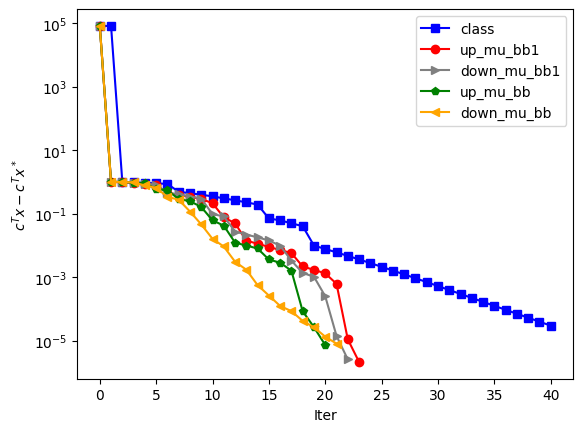

In [27]:

plt.plot(f,'s-',label='class',color='blue')
plt.plot(f1,'o-',label='up_mu_bb1',color='red')
plt.plot(f2,'>-',label='down_mu_bb1',color='gray')
plt.plot(f3,'p-',label='up_mu_bb',color='green')
plt.plot(f4,'<-',label='down_mu_bb',color='orange')
plt.xlabel('Iter')
plt.ylabel(r'$c^Tx-c^Tx^*$')
plt.legend()
plt.yscale('log')
plt.show()

In [15]:
gap4,k4,f4,u4,cx4,by4,ax4,ay4,muy4,cxby4=impro4(A,b,c,y,x,s,ep,gap,thet,Z1,Z2,Z3,I,zvm,zvn,eee,alp,n,m,mu)


Imporved Algorithm
